In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()

import datetime
from __future__ import division

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
import string

%matplotlib inline

In [247]:
# NTEE file import to DF
df_ntee = pd.read_csv('NTEE_EINs.csv', delimiter='|')
df_ntee['EIN'], df_ntee['NTEE'] = df_ntee['EIN,"NteeFinal"'].str.split(',',1).str
df_ntee = df_ntee.drop('EIN,"NteeFinal"', axis=1)

In [248]:
# split NTEE letter and code
letter = []
code = []
for i in df_ntee['NTEE'].values:
    try:
        letter.append(i[1])
        code.append(i[2:-1])
    except:
        letter.append('Null')
        code.append('Null')

df_ntee['letter'], df_ntee['code'] = letter, code

In [249]:
to_int = []
for i in df_ntee['EIN'].values:
    try:
        to_int.append(int(i))
    except:
        to_int.append(i)

df_ntee.drop('EIN', axis=1)
df_ntee['EIN'] = to_int

In [252]:
df_ntee.head()

,EIN,NTEE,letter,code
0,1,"""B40""",B,40
1,4,"""B90""",B,90
2,5,"""A50""",A,50
3,2704,"""Z99""",Z,99
4,3154,"""C36""",C,36


NTEE that appear less than 2 times: 15.45%
NTEE that appear less than 10 times: 45.76%
NTEE that appear less than 50 times: 66.57%
NTEE that appear less than 100 times: 73.98%
NTEE that appear less than 500 times: 85.07%


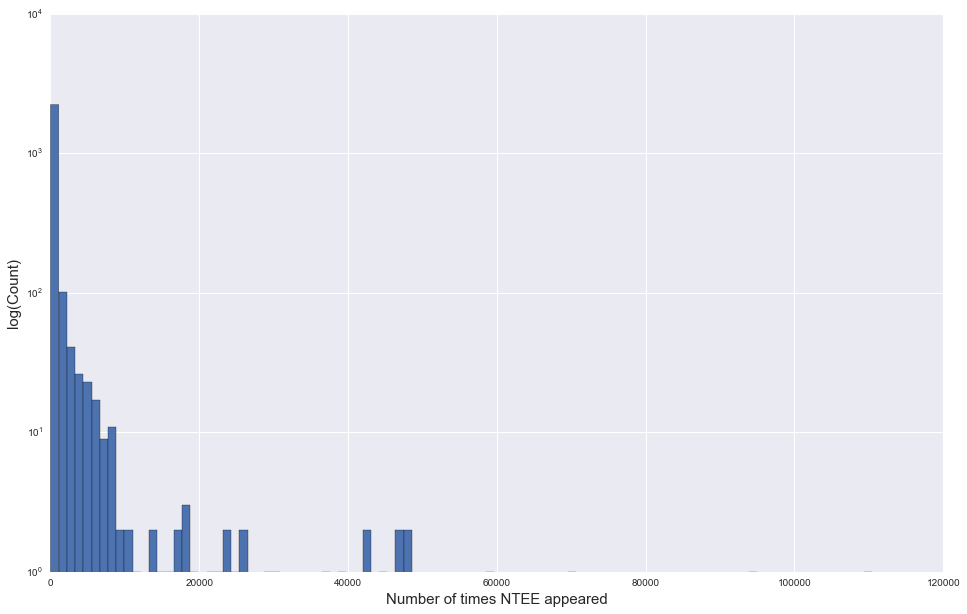

In [212]:
ntee_counts = df_ntee.groupby('NTEE')['NTEE'].count()

for i in [2, 10, 50, 100, 500]:
    print('NTEE that appear less than {} times: {}%'.format(i, round((ntee_counts < i).mean() * 100, 2)))

plt.figure(figsize=(16, 10))
plt.hist(ntee_counts.values, bins=100, log=True)
plt.xlabel('Number of times NTEE appeared', fontsize=15)
plt.ylabel('log(Count)', fontsize=15)
plt.show()

In [198]:
# NTEE counts in dataset
ntee_counts.sort_values(ascending=False)

NTEE
"X20"      110397
"X21"       94247
"T20"       70266
"W30"       59506
"T90"       48406
"Z99"       48071
"S80"       47153
"B94"       46767
"T99"       44489
"J40"       43032
"N50"       41993
"Y41"       38996
"B83"       36823
"N60"       29959
"T22"       28711
"B82"       26358
"S20"       25647
"O50"       25238
"Y42"       23451
"B11"       23280
"S41"       22316
"P20"       21921
"A23"       18923
"M24"       18541
"Y40"       18514
"D20"       17916
"N63"       17335
"B03"       17319
"B99"       16494
"A80"       15217
            ...  
"G0230"         1
"G0161"         1
"G0144"         1
"S1231"         1
"S1243"         1
"S1282"         1
"S1943"         1
"F1980"         1
"F1960"         1
"G0398"         1
"G0543"         1
"G0580"         1
"G1925"         1
"G1950"         1
"G1948"         1
"G1943"         1
"G1942"         1
"G1941"         1
"G1940"         1
"G1932"         1
"G1294"         1
"G0590"         1
"G1250"         1
"G1245"         1
"G124

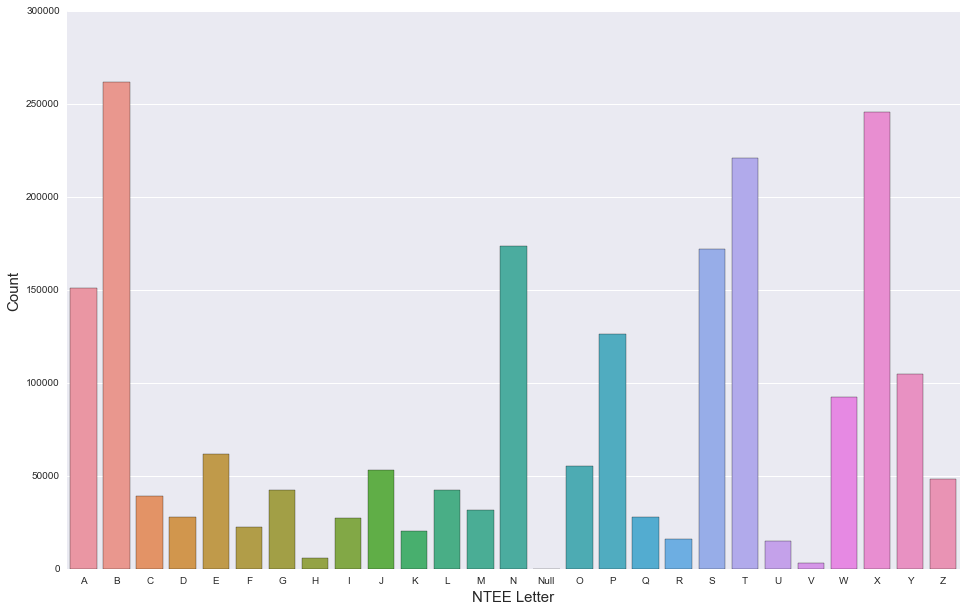

In [213]:
# NTEE letter counts
letter_counts = df_ntee.groupby('letter')['letter'].count()

plt.figure(figsize=(16, 10))
sns.barplot(letter_counts.index, letter_counts.values)
plt.xlabel('NTEE Letter', fontsize=15)
plt.ylabel('Count', fontsize=15)

In [200]:
# NTEE letter counts
letter_counts.sort_values(ascending=False)

letter
B       261583
X       245722
T       220758
N       173817
S       171821
A       151070
P       126224
Y       104527
W        92172
E        61942
O        55351
J        53051
Z        48071
L        42510
G        42208
C        39307
M        31862
D        27898
Q        27777
I        27166
F        22261
K        20287
R        15789
U        14705
H         5560
V         3185
Null        74
Name: letter, dtype: int64

In [68]:
# import descriptions file, combine useful text features into df_text
df_desc = pd.read_csv("nonprofit-descriptions_2016.csv", delimiter='|')
df_text = df_desc[['EIN', 'orgName','activityDesc','missionDesc','proj1Desc']]
df_text["text_blob"] = df_text["orgName"] + df_text["activityDesc"] + df_text["missionDesc"] + df_text["proj1Desc"]


/Users/nickryan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [88]:
# filter for text values only
df_text = df_text[df_text['text_blob'].apply(type)==str]

In [89]:
# cluster text with tf-idf and k-means
# tune max_df (document frequency): low values mean low overlap between clusters
def clusters_tfidf(df, feature, clusters_count = 25, num_terms = 10):
    vect = TfidfVectorizer(max_df = 0.02, max_features = None,
                                 stop_words = text.ENGLISH_STOP_WORDS.union(string.punctuation),
                                 use_idf = True, tokenizer = None, ngram_range=(1, 1))
    matrix = vect.fit_transform(df[feature]) 
    terms = vect.get_feature_names()
    km = KMeans(n_clusters = clusters_count, random_state=0)
    km.fit(matrix)
    clusters = km.labels_.tolist()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    store = []
    for i in range(clusters_count):
        cluster_num = "Cluster %d:" % (i + 1)
        topics = ', '.join([terms[ind] for ind in order_centroids[i, :num_terms]])
        cluster_topics = cluster_num + ' ' + topics
        store.append(cluster_topics)
    return store

In [214]:
# e.g. for 10 clusters and 10 terms:

[u'Cluster 1: museum, historical, historic, preservation, exhibits, artifacts, heritage, collection, exhibitions, visitors',
 u'Cluster 2: library, needy, god, developmentally, jesus, rescue, protection, camp, preschool, ministries',
 u'Cluster 3: animals, animal, humane, spay, adoption, cats, dogs, neuter, pet, rescue',
 u'Cluster 4: theatre, performing, dance, performances, artists, theater, symphony, productions, performance, musical',
 u'Cluster 5: soccer, baseball, hockey, league, players, play, sportsmanship, little, teams, game',
 u'Cluster 6: charter, ymca, montessori, grades, mind, body, spirit, principles, kindergarten, strong',
 u'Cluster 7: girls, boys, productive, responsible, enable, character, clubs, especially, girl, inspire',
 u'Cluster 8: handicapped, hud, 202, apartment, rental, complex, subsidized, moderate, agreement, psychological',
 u'Cluster 9: cancer, violence, domestic, victims, sexual, assault, crisis, breast, survivors, intervention',
 u'Cluster 10: jewish, 

In [215]:
# e.g. 25 clusters and 15 terms:

[u'Cluster 1: needy, athletic, scientific, scholarship, memorial, preschool, catholic, park, elementary, charities, hockey, grades, texas, council, welfare',
 u'Cluster 2: jesus, gospel, god, ministries, churches, bible, word, love, spread, biblical, faith, missions, pastors, missionaries, evangelism',
 u'Cluster 3: drug, alcohol, substance, recovery, addiction, men, outpatient, drugs, alcoholism, problems, dependency, recovering, chemical, behavioral, disorders',
 u'Cluster 4: violence, domestic, victims, sexual, assault, crisis, survivors, intervention, legal, rape, hotline, hour, victim, temporary, end',
 u'Cluster 5: museum, exhibits, historical, exhibitions, artifacts, collection, visitors, collections, historic, display, heritage, exhibition, hands, museums, tours',
 u'Cluster 6: hud, 202, apartment, rental, complex, subsidized, agreement, apartments, 811, urban, regulated, pursuant, tenants, rent, owns',
 u'Cluster 7: montessori, preschool, method, elementary, maria, philosophy,

In [384]:
df_merged = pd.merge(df_text, df_ntee, on='EIN', how='inner')

In [385]:
ntee_dict = { 
'B':[4],
'C':[12, 13, 14, 15, 16],
'F':[3],
'G':[3],
'H':[3],
'J':[8],
'K':[2],
'L':[1]}

In [386]:
sdg = []
for i in df_merged['letter'].values:
    try:
        sdg.append(ntee_dict[i])
    except:
        sdg.append([0])

In [387]:
df_merged['SDG'] = sdg

In [388]:
from sklearn.preprocessing import MultiLabelBinarizer
y = df_merged.SDG
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)

In [391]:
mlb.classes_

array([ 0,  1,  2,  3,  4,  8, 12, 13, 14, 15, 16])

In [393]:
SDG_dict = {0:"0: Unassigned",
            1:"1: No Poverty", 
            2:"2: Zero Hunger",
            3:"3: Good Health and Well-being",
            4:"4: Quality Education",
            5:"5: Gender Equality",
            6:"6: Clean Water and Sanitation",
            7:"7: Affordable and Clean Energy",
            8:"8: Decent Work and Economic Growth",
            9:"9: Industry, Innovation, and Infrastructure",
            10:"10: Reduced Inequalities",
            11:"11: Sustainable Cities and Communities",
            12:"12: Responsible Consumption and Production",
            13:"13: Climate Action",
            14:"14: Life Below Water",
            15:"15: Life on Land",
            16:"16: Peace, Justice, and Strong Institutions",
            17:"17: Partnerships for the Goals"}

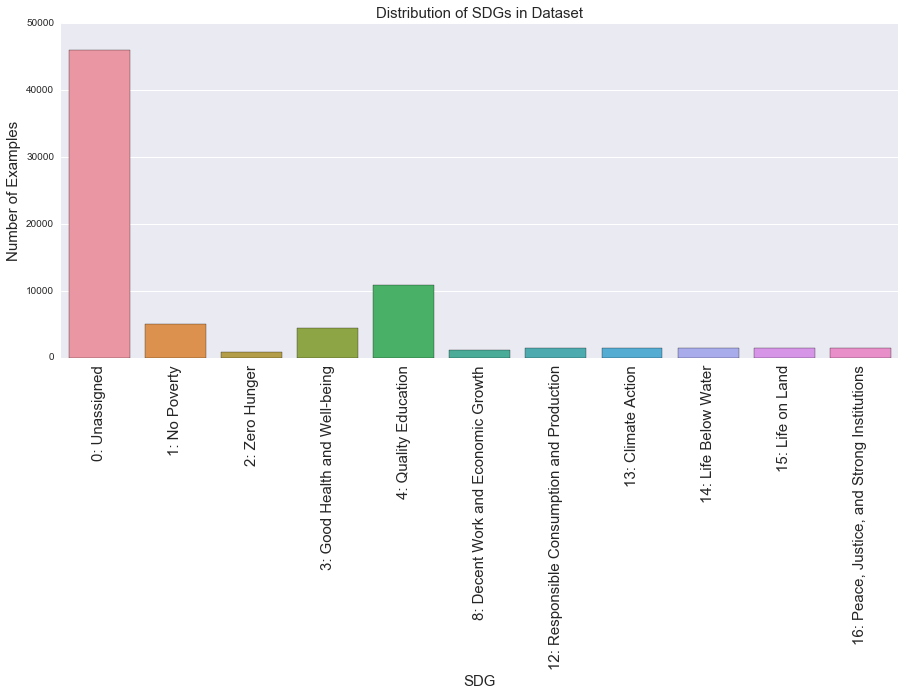

In [394]:
plt.figure(figsize=(15, 6))
plt.xticks(rotation='vertical', fontsize = 15)
plt.title('Distribution of SDGs in Dataset', fontsize = 15)
plt.ylabel('Number of Examples', fontsize = 15)
plt.xlabel('SDG', fontsize = 15)
sns.barplot([SDG_dict[int(i)] for i in list(mlb.classes_)], y.sum(axis=0))